In [47]:
from sklearn.datasets import fetch_olivetti_faces

In [48]:
# Load the dataset
faces = fetch_olivetti_faces()

# Access the images and target labels
X = faces.data
y = faces.target

In [49]:
import math

print(X.shape)
print(len(set(y)))
print(math.sqrt(X.shape[1]))

(400, 4096)
40
64.0


Dataset contains 400 images of 64x64 grayscale pixels, 10 images of 40 different subjects.

In [50]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=86)

print(f"Training set size: {len(X_train)}")
print(f"Test set size: {len(X_test)}")

Training set size: 320
Test set size: 80


## Scale the input data

In [51]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Optional: reduce dimentions using PCA

In [52]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca.fit(X_train)

print(pca.explained_variance_ratio_)
print(f"Cumulative explained variance: {sum(pca.explained_variance_ratio_)}")

[0.26517442 0.12464918]
Cumulative explained variance: 0.3898236006498337


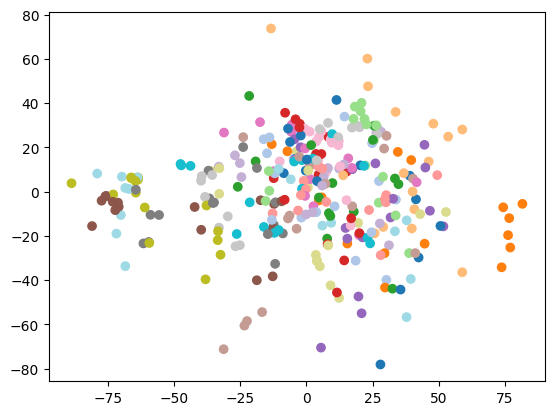

In [53]:
# plot the first two principal components
import matplotlib.pyplot as plt

X_train_pca = pca.transform(X_train)
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_train, cmap='tab20')

In [54]:
# PCA with 95% explained variance
pca = PCA(n_components=0.95)
pca.fit(X_train)
print(f"Number of components to explain 95% of the variance: {pca.n_components_}")

X_train_pca = pca.transform(X_train)
print(f"Shape of X_train_pca: {X_train_pca.shape}")
print(f"Shape of X_train: {X_train.shape}")

Number of components to explain 95% of the variance: 110
Shape of X_train_pca: (320, 110)
Shape of X_train: (320, 4096)


## Training a classifier

In [55]:
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

kf = KFold(n_splits=5, shuffle=True, random_state=86)
classifier = LogisticRegression(max_iter=1000)

# List to store accuracy for each fold
accuracies = []

for train_index, val_index in kf.split(X_train_pca):
    X_train_fold, X_val = X_train_pca[train_index], X_train_pca[val_index]
    y_train_fold, y_val = y_train[train_index], y_train[val_index]
    
    # Train the classifier
    classifier.fit(X_train_fold, y_train_fold)
    
    # Predict on the validation set
    y_pred = classifier.predict(X_val)
    
    # Calculate accuracy
    accuracy = accuracy_score(y_val, y_pred)
    accuracies.append(accuracy)

# Print the average accuracy across all folds
print(f"Average accuracy: {sum(accuracies) / len(accuracies)}")
print(f"Test accuracy: {classifier.score(pca.transform(X_test), y_test)}")

Average accuracy: 0.9625
Test accuracy: 0.975


In [56]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import numpy as np

silhouette_scores = []
k_values = range(2, X_train_pca.shape[1])

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=86)
    kmeans.fit(X_train_pca)
    silhouette_scores.append(silhouette_score(X_train_pca, kmeans.labels_))

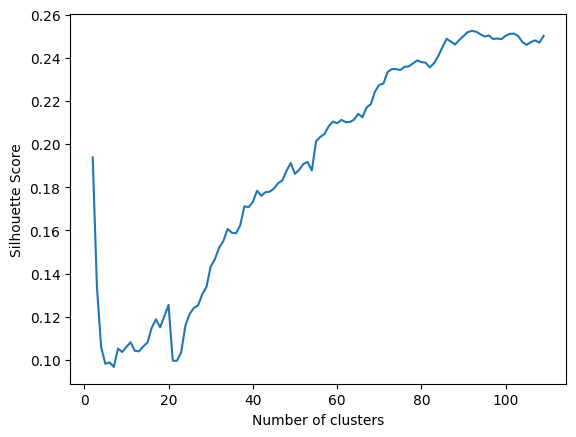

Optimal number of clusters: 92


In [57]:
plt.plot(k_values, silhouette_scores)
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.show()

print(f"Optimal number of clusters: {np.argmax(silhouette_scores) + 2}")

In [58]:
kmeans = KMeans(n_clusters=92, random_state=86)
kmeans.fit(X_train_pca)

X_train_kmeans = kmeans.transform(X_train_pca)
X_test_kmeans = kmeans.transform(pca.transform(X_test))

print(X_train_kmeans.shape)

(320, 92)


## Train a classifier with output from kmeans

In [59]:
classifier = LogisticRegression(max_iter=1000)

for train_index, val_index in kf.split(X_train_kmeans):
    X_train_fold, X_val = X_train_kmeans[train_index], X_train_kmeans[val_index]
    y_train_fold, y_val = y_train[train_index], y_train[val_index]
    
    # Train the classifier
    classifier.fit(X_train_fold, y_train_fold)
    
    # Predict on the validation set
    y_pred = classifier.predict(X_val)
    
    # Calculate accuracy
    accuracy = accuracy_score(y_val, y_pred)
    accuracies.append(accuracy)

# Print the average accuracy across all folds
print(f"Average accuracy: {sum(accuracies) / len(accuracies)}")
print(f"Test accuracy: {classifier.score(X_test_kmeans, y_test)}")

Average accuracy: 0.9421875
Test accuracy: 0.9375


# DBSCAN

 Preprocess the images and convert them into feature vectors, then use DBSCAN to group similar images together based on their density. Provide your rationale for the similarity measure used to perform the clustering, considering the nature of facial image data

## Load Images

In [60]:
from sklearn.datasets import fetch_olivetti_faces

# Load the dataset
faces = fetch_olivetti_faces()
X = faces.data  # Shape: (400, 64*64)

# Reshape to original image size (400, 64, 64)
images = X.reshape(-1, 64, 64)

## Preprocess the images

In [116]:
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications.mobilenet_v3 import preprocess_input
import numpy as np

# Prepare images for movile net v2
X_resized = np.array([img_to_array(np.repeat(img[..., np.newaxis], 3, axis=-1)) for img in images])
print(X_resized.shape)

X_preprocessed = preprocess_input(X_resized)
print(X_preprocessed.shape)

(400, 64, 64, 3)
(400, 64, 64, 3)


## Feature extraction

In [117]:
from tensorflow.keras.applications import MobileNetV3Small

# Load MobileNetV2 model without the top layer
model = MobileNetV3Small(weights='imagenet', include_top=False, input_shape=(64, 64, 3))

# Extract features
features = model.predict(X_preprocessed)
print(features.shape)

/Users/oscarumana/Documents/venv/lib/python3.9/site-packages/keras/src/applications/mobilenet_v3.py:452: UserWarning: `input_shape` is undefined or non-square, or `rows` is not 224. Weights for input shape (224, 224) will be loaded as the default.
  return MobileNetV3(


4334752/4334752 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step
(400, 2, 2, 576)


In [118]:
# Flatten the feature maps
features_flattened = features.reshape(features.shape[0], -1)
features_flattened.shape

(400, 2304)

In [119]:
from sklearn.preprocessing import Normalizer
normalizer = Normalizer()
features_scaled = normalizer.fit_transform(features_flattened)

## Clustering

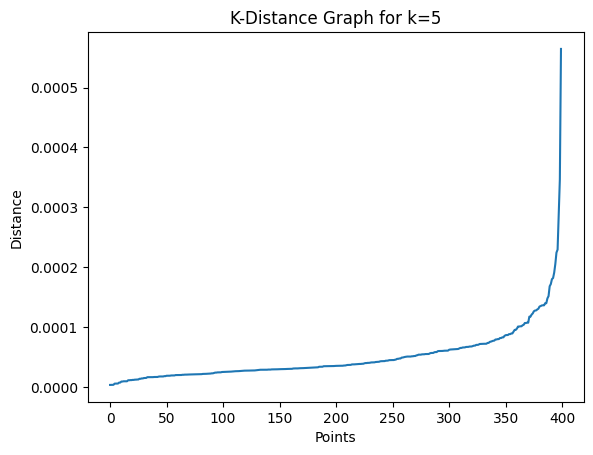

In [124]:
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors

def plot_k_distance(X, k):
    neighbors = NearestNeighbors(n_neighbors=k, metric="cosine")
    neighbors_fit = neighbors.fit(X)
    distances, indices = neighbors_fit.kneighbors(X)
    distances = np.sort(distances, axis=0)
    distances = distances[:, 1]
    plt.plot(distances)
    plt.xlabel('Points')
    plt.ylabel('Distance')
    plt.title(f'K-Distance Graph for k={k}')
    plt.show()

plot_k_distance(features_scaled, k=5)

In [131]:
dbscan = DBSCAN(eps=0.0001, min_samples=5, metric='cosine')
dbscan.fit(features_scaled)

print(f"Number of clusters: {len(set(dbscan.labels_))}")

Number of clusters: 10


In [132]:
# print the number of points in each cluster
from collections import Counter
print(Counter(dbscan.labels_))

Counter({1: 209, -1: 118, 0: 26, 7: 10, 4: 9, 2: 8, 3: 5, 5: 5, 6: 5, 8: 5})


Cluster 0:


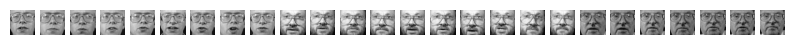

Cluster 1:


Cluster 2:


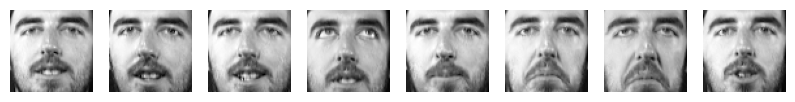

Cluster 3:


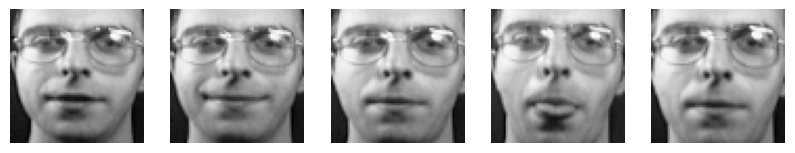

Cluster 4:


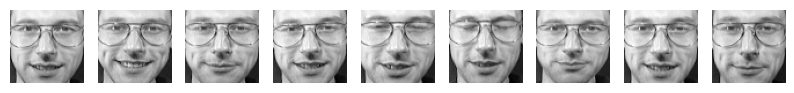

Cluster 5:


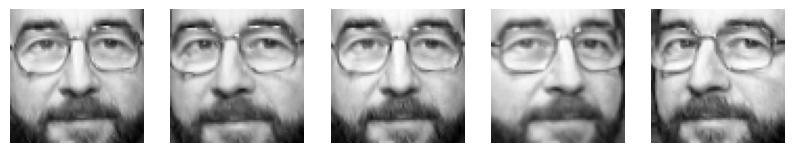

Cluster 6:


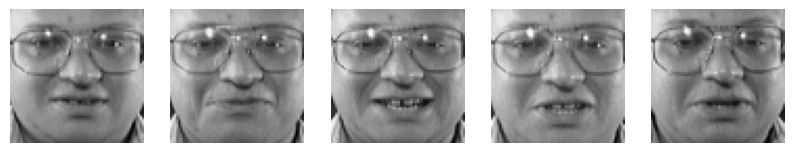

Cluster 7:


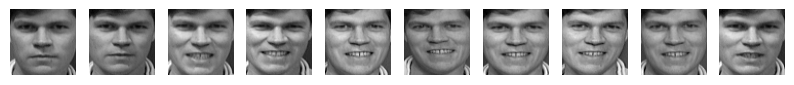

Cluster 8:


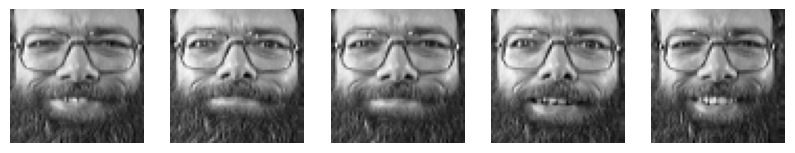

Cluster -1:


<Figure size 1000x500 with 0 Axes>

In [133]:
labels = dbscan.labels_
# Create a dictionary to store images for each cluster
cluster_images = {label: [] for label in set(labels)}

# Iterate through the labels and add images to the corresponding cluster
for i, label in enumerate(labels):
  if label != -1:
    cluster_images[label].append(images[i])

# Plot images for each cluster
for label, images_in_cluster in cluster_images.items():
  print(f"Cluster {label}:")
  plt.figure(figsize=(10, 5))
  for i, img in enumerate(images_in_cluster):
    plt.subplot(1, len(images_in_cluster), i + 1)
    plt.imshow(img, cmap='gray')
    plt.axis('off')
  plt.show()